In [1]:
 import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from read_db.CH import Getch

In [3]:
 query = """
    SELECT
        exp_group
        , user_id
        , countIf(action='like') AS likes
        , countIf(action='view') AS views
        , likes / views AS ctr
    FROM simulator_20220520.feed_actions
    WHERE toDate(time) >= '2022-04-24' 
        AND toDate(time) <= '2022-04-30'
        AND exp_group IN (0, 1, 2, 3)
    GROUP BY exp_group, user_id
"""
    
df = Getch(query).df

In [5]:
# рассчитаем controlCTR для наших пар
group0_ctr = df.query("exp_group == 0")['likes'].sum() / df.query("exp_group == 0")['views'].sum()
group1_ctr = df.query("exp_group == 1")['likes'].sum() / df.query("exp_group == 1")['views'].sum()

#рассчитаем новую метрику
df['linearized_likes'] = df.apply(lambda x: x.likes - group0_ctr * x.views if x.exp_group in (0, 3) else x.likes - group1_ctr * x.views, axis=1)

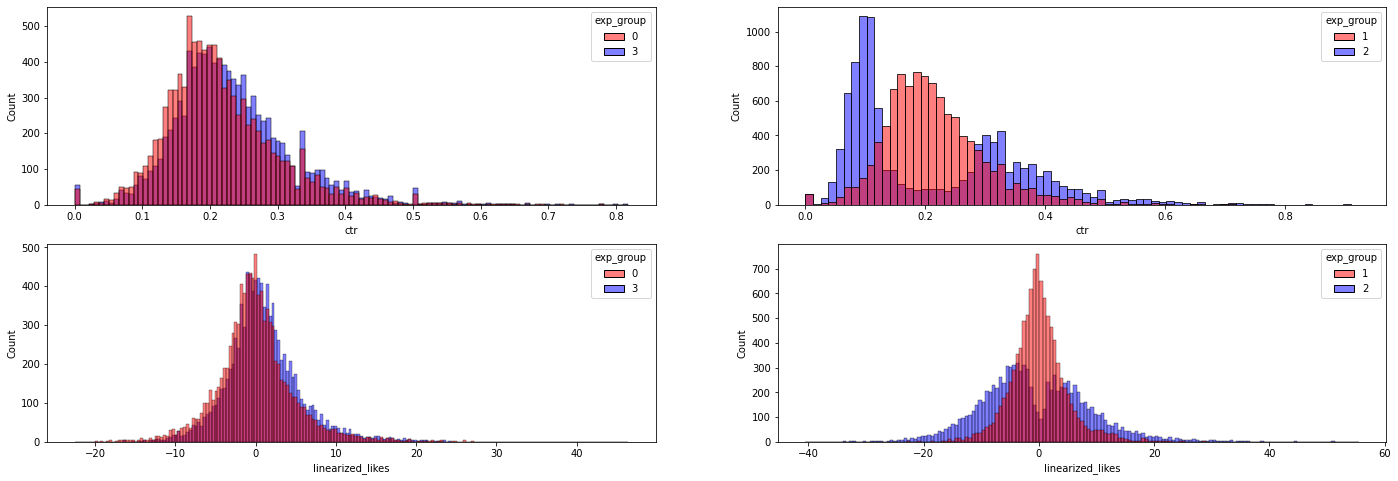

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 8))

sns.histplot(data=exp_df.query("exp_group in (0, 3)"),
             x='ctr',
             hue='exp_group',
             palette = ['r', 'b'],
             ax=ax[0, 0],
             alpha=0.5,
             kde=False)

sns.histplot(data=exp_df.query("exp_group in (0, 3)"),
             x='linearized_likes',
             hue='exp_group',
             palette = ['r', 'b'],
             ax=ax[1, 0],
             alpha=0.5,
             kde=False)

sns.histplot(data=exp_df.query("exp_group in (1, 2)"),
             x='ctr',
             hue='exp_group',
             palette = ['r', 'b'],
             ax=ax[0, 1],
             alpha=0.5,
             kde=False)

sns.histplot(data=exp_df.query("exp_group in (1, 2)"),
             x='linearized_likes',
             hue='exp_group',
             palette = ['r', 'b'],
             ax=ax[1, 1],
             alpha=0.5,
             kde=False)

plt.show()

In [11]:
ttest_ind(df[df['exp_group'] == 0]['ctr'],
          df[df['exp_group'] == 3]['ctr'],
          equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [14]:
ttest_ind(df[df['exp_group'] == 0]['linearized_likes'],
          df[df['exp_group'] == 3]['linearized_likes'],
          equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

По группам 0 и 3 в обоих случаях полчаем стат. значимую разницу, но при использовании новой местрики чувствительность увеличилась

In [17]:
ttest_ind(df[df['exp_group'] == 1]['linearized_likes'],
          df[df['exp_group'] == 2]['linearized_likes'],
          equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

Из прошлого задания мы знаем что т тест на группах 1 и 2 не показывает стат. значимую разницу без модификаций (бустреп, бакетное распределение, сглаживание).

После линералиции мы видим что т тест позволил нам выявить различия в группах. 